<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SigLIP/Fine_tuning_SigLIP_and_friends_for_multi_label_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune SigLIP and friends for multi-label image classification

In this notebook, I'll show how one can fine-tune any pre-trained vision model from the Transformers library for multi-label image classification.

It's the computer vision counterpart of a [similar notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb) I made for multi-label text classification with BERT and friends.

As we'll see, the API is pretty identical, the only difference is that we now need to prepare images (`pixel_values`) for the model rather than text (`input_ids` and `attention_mask`). As every vision model in the library has the same API, one can plug in any pre-trained image encoder from the [hub](https://huggingface.co/). Here we'll use [SigLIP](https://huggingface.co/docs/transformers/en/model_doc/siglip) as it's one of the strongest vision encoders at the time of writing.

Note: you'll need to run this notebook on a GPU.

## Set-up environment

Let's start by installing 🤗 Transformers and 🤗 Datasets.

In [ ]:
# we're installing from source since the model we will be using is brand new at the time of writing
!pip install --upgrade git+https://github.com/huggingface/transformers.git

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 231789, done.
remote: Counting objects: 100% (590/590), done.
remote: Compressing objects: 100% (434/434), done.
remote: Total 231789 (delta 285), reused 337 (delta 118), pack-reused 231199
Receiving objects: 100% (231789/231789), 223.25 MiB | 14.09 MiB/s, done.
Resolving deltas: 100% (164277/164277), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


## Load CSV

We'll download a multi-label image classification dataset from here: https://www.kaggle.com/datasets/meherunnesashraboni/multi-label-image-classification-dataset?resource=download.

Next, let's read the associated csv as a Pandas dataframe. Each row consists of a training example, containing the filename of an image and the corresponding one-hot encoded labels. This is exactly the format we need for multi-label classification :)

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/ConvNext/Tutorial notebooks/Data/multilabel_modified/multilabel_classification(2).csv")
df.head()

,Image_Name,"Classes(motorcycle, truck, boat, bus, cycle, person, desert, mountains, sea, sunset, trees, sitar, ektara, flutes, tabla, harmonium)",motorcycle,truck,boat,bus,cycle,person,desert,mountains,sea,sunset,trees,sitar,ektara,flutes,tabla,harmonium
0,image1.jpg,bus person,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1,image2.jpg,sitar,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,image3.jpg,flutes,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,image4.jpg,bus trees,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,image5.jpg,bus,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Let's check one example:

In [ ]:
df.iloc[62].values

array(['image63.jpg', '  person tabla', 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0], dtype=object)

In [ ]:
df.iloc[0][2:].values

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [ ]:
labels = list(df.columns)[2:]
print(labels)

['motorcycle', 'truck', 'boat', 'bus', 'cycle', 'person', 'desert', 'mountains', 'sea', 'sunset', 'trees', 'sitar', 'ektara', 'flutes', 'tabla', 'harmonium']


We create an id2label dictionary which maps integers to strings.

In [ ]:
id2label = {id: label for id, label in enumerate(labels)}
print(id2label)

{0: 'motorcycle', 1: 'truck', 2: 'boat', 3: 'bus', 4: 'cycle', 5: 'person', 6: 'desert', 7: 'mountains', 8: 'sea', 9: 'sunset', 10: 'trees', 11: 'sitar', 12: 'ektara', 13: 'flutes', 14: 'tabla', 15: 'harmonium'}


## Load model and image processor

Next, let's instantiate a pre-trained model from the hub, and add a randomly initialized classification head on top.

* At the time of writing this notebook, [SigLIP](https://huggingface.co/docs/transformers/en/model_doc/siglip) is one of the best pre-trained image encoders, hence we'll use a checkpoint of it. It has been pre-trained on a lot of image-text pairs in a contrastive fashion similar to [CLIP](https://huggingface.co/docs/transformers/en/model_doc/clip). Note that you can specify any image classifier supported [here](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification.from_pretrained)!

* We also specify the `problem_type` to be "multi_label_classification". This makes sure that the appropriate loss function will be used when passing labels to the model (which in the case of multi-label classification is the [binary cross-entropy loss with logits](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)).
* Finally we also pass the id2label mapping, which will make it easy to map integer labels back to text at inference time.

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_id = "google/siglip-so400m-patch14-384"

processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForImageClassification.from_pretrained(model_id, problem_type="multi_label_classification", id2label=id2label)

config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

Some weights of SiglipForImageClassification were not initialized from the model checkpoint at google/siglip-so400m-patch14-384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create PyTorch Dataset

Next we'll create a regular PyTorch dataset, which prepares the data for the model. Each training example consists of 2 things:
* pixel_values, which is the image prepared in the format that the model expects
* labels, the corresponding multiple labels, as a one-hot encoded vector.

In [ ]:
from torch.utils.data import Dataset
import torch
from PIL import Image
import os
import numpy as np

class MultiLabelDataset(Dataset):
  def __init__(self, root, df, transform):
    self.root = root
    self.df = df
    self.transform = transform

  def __getitem__(self, idx):
    item = self.df.iloc[idx]
    # get image
    image_path = os.path.join(self.root, item["Image_Name"])
    image = Image.open(image_path).convert("RGB")

    # prepare image for the model
    pixel_values = self.transform(image)

    # get labels
    labels = item[2:].values.astype(np.float32)

    # turn into PyTorch tensor
    labels = torch.from_numpy(labels)

    return pixel_values, labels

  def __len__(self):
    return len(self.df)

To prepare the images for the model, we'll use the [Torchvision](https://pytorch.org/vision/stable/index.html) package which provides several nice image transformations which we can use. Of course, feel free to use another library here, like Albumentations.

The most important thing to keep in mind here is that images need to be resized to the size that the model expects (which in this case is 384), and that we normalize the color channels with the appropriate mean and standard deviation. These properties can all be found from the image processor, which is a minimal object typically used for inference only.

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# get appropriate size, mean and std based on the image processor
size = processor.size["height"]
mean = processor.image_mean
std = processor.image_std

transform = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=mean, std=std),
])

train_dataset = MultiLabelDataset(root="/content/drive/MyDrive/ConvNext/Tutorial notebooks/Data/multilabel_modified/images",
                                  df=df, transform=transform)

In [ ]:
pixel_values, labels = train_dataset[63]
print(pixel_values.shape)

torch.Size([3, 384, 384])


Let's verify the preprocessed image by "denormalizing" the pixel values:

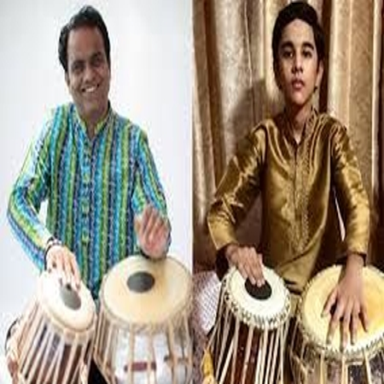

In [ ]:
unnormalized_image = (pixel_values.numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Let's verify the corresponding one-hot encoded vector of labels applicable to this image:

In [ ]:
labels

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [ ]:
torch.nonzero(labels).squeeze().tolist()

[5, 14]

In [ ]:
[id2label[label] for label in torch.nonzero(labels).squeeze().tolist()]

['person', 'tabla']

## Create PyTorch DataLoader

Cool! Next we can create a corresponding [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), in order to get batches of training examples (as neural networks are typically trained on batches of data using stochastic gradient descent = SGD).

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    data = torch.stack([item[0] for item in batch])
    target = torch.stack([item[1] for item in batch])
    return data, target

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=2, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
print(batch)

(tensor([[[[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, 

In [ ]:
print(batch[0].shape)
print(batch[1].shape)

torch.Size([2, 3, 384, 384])
torch.Size([2, 16])


## Verify initial loss

In [ ]:
outputs = model(pixel_values=batch[0].to(device), labels=batch[1].to(device))

In [ ]:
outputs.loss

tensor(0.2510, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## Train the model

It's time to train the model! We'll train in regular PyTorch fashion here, but feel free to upgrade to leverage 🤗 [Accelerate](https://huggingface.co/docs/accelerate/index) (very useful for distributed training with minimal code changes), or leverage the 🤗 [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class which handles a lot of the logic we're defining here for you (like creating dataloaders).

NOTE: this notebook is only made for demo purposes. There's a lot to improve/tweak here:
- learning rate
- number of epochs
- optimizer
- gradient accumulation, gradient checkpointing, Flash Attention can be leveraged to speed up training
- mixed precision training (bfloat16) etc.

If you want a lot of this to be easily configurable, I'd recommend using the [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) API. For example usage, I refer to the [example script](https://github.com/huggingface/transformers/blob/main/examples/pytorch/image-classification/run_image_classification.py).

In [ ]:
# handy utility I found at https://github.com/wenwei202/pytorch-examples/blob/ecbb7beb0fac13133c0b09ef980caf002969d315/imagenet/main.py#L296
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from torch.optim import AdamW
from tqdm.auto import tqdm

# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

losses = AverageMeter()

model.train()
for epoch in range(10):  # loop over the dataset multiple times
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values, labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(
            pixel_values=pixel_values.to(device),
            labels=labels.to(device),
        )

        # calculate gradients
        loss = outputs.loss
        losses.update(loss.item(), pixel_values.size(0))
        loss.backward()

        # optimization step
        optimizer.step()

        if idx % 100 == 0:
            print('Epoch: [{0}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   epoch, loss=losses,))

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [0]	Loss 0.1449 (0.1449)	


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [1]	Loss 0.0764 (0.1719)	


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [2]	Loss 0.0782 (0.1438)	


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [3]	Loss 0.0125 (0.1274)	


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [4]	Loss 0.1694 (0.1141)	


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [5]	Loss 0.0600 (0.1039)	


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [6]	Loss 0.1585 (0.0966)	


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [7]	Loss 0.0013 (0.0891)	


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [8]	Loss 0.1019 (0.0857)	


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [9]	Loss 0.0029 (0.0847)	


## Inference

Let's showcase inference on a new image.

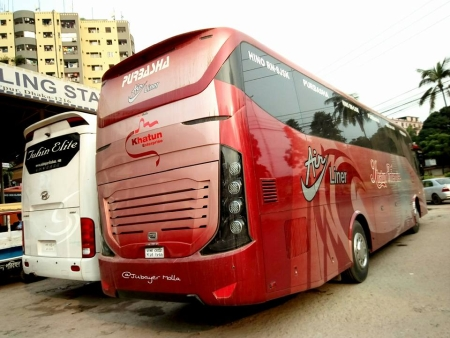

In [ ]:
# load image to test on
image = Image.open("/content/drive/MyDrive/ConvNext/Tutorial notebooks/Data/multilabel_modified/images/image6179.jpg")
image

In [ ]:
model.eval()

# prepare image for the model
pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# forward pass
with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

Note: as we used the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) during training (which applies a sigmoid on the logits before calculating a loss), we need to apply sigmoid to the logits here as well. This turns them into individual probabilities.

In [ ]:
# turn into probabilities by applying sigmoid
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())

# select the probabilities > a certain threshold (e.g. 50%) as predicted
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1 # turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['truck']


I barely trained the model on only 50 examples for debugging purposes, and it looks like training is working (model is predicting "truck" here instead of "bus" but would require more training).